# Source Bias & Domain Quality Analysis

**Goal:** Investigate patterns in news source behavior to identify potential biases and quality signals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Load data
from pathlib import Path

# Find project root by walking up from current directory until we find 'data' directory
# Works whether notebook is run from project root or from a subdirectory
current = Path.cwd()
while not (current / "data").exists() and current != current.parent:
    current = current.parent
PROJECT_ROOT = current
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "gdelt_articles_with_sentiment.csv"

df = pd.read_csv(INPUT_PATH, parse_dates=["seendate"])
assert "sentiment_score" in df.columns, "Input CSV must have a 'sentiment_score' column."
print(f"Loaded {len(df):,} rows from {INPUT_PATH.name}")

print(f"Date range: {df['seendate'].min().date()} to {df['seendate'].max().date()}")
print(f"\nUnique domains: {df['domain'].nunique()}")

Loaded 2,909 rows from gdelt_articles_with_sentiment.csv
Date range: 2026-01-05 to 2026-02-09

Unique domains: 556


## 1. Domain Concentration: Who Controls the Narrative?

Understanding if our sentiment signal is dominated by a few sources vs. diversified across many.

In [3]:
# Domain coverage analysis
domain_counts = df['domain'].value_counts()
total_articles = len(df)

# Top 15 domains
top_domains = domain_counts.head(15)
top_domains_pct = (top_domains / total_articles * 100).round(1)

# Concentration metrics
top_5_coverage = (domain_counts.head(5).sum() / total_articles * 100)
top_10_coverage = (domain_counts.head(10).sum() / total_articles * 100)


print("=" * 50)
print("Domain Concentration:")
print("=" * 50)
print(f"Top 5 domains cover: {top_5_coverage:.1f}% of all articles")
print(f"Top 10 domains cover: {top_10_coverage:.1f}% of all articles")
print(f"\nTotal unique domains: {len(domain_counts)}")
print(f"\nDomains with only 1 article: {(domain_counts == 1).sum()}")
print(f"Domains with 10+ articles: {(domain_counts >= 10).sum()}")

print("=" * 60)
print("Top 15 Domains by Article Count:")
print("=" * 60)
for domain, count in top_domains.items():
    pct = (count / total_articles * 100)
    print(f"{domain:40s} {count:4d} articles ({pct:5.1f}%)")

Domain Concentration:
Top 5 domains cover: 40.4% of all articles
Top 10 domains cover: 49.7% of all articles

Total unique domains: 556

Domains with only 1 article: 330
Domains with 10+ articles: 37
Top 15 Domains by Article Count:
finance.yahoo.com                         439 articles ( 15.1%)
markets.financialcontent.com              320 articles ( 11.0%)
fool.com                                  227 articles (  7.8%)
webpronews.com                            100 articles (  3.4%)
benzinga.com                               90 articles (  3.1%)
economictimes.indiatimes.com               60 articles (  2.1%)
cnbc.com                                   59 articles (  2.0%)
themarketsdaily.com                        56 articles (  1.9%)
insidermonkey.com                          52 articles (  1.8%)
dailypolitical.com                         42 articles (  1.4%)
marketscreener.com                         41 articles (  1.4%)
tickerreport.com                           37 articles (  1.3%)

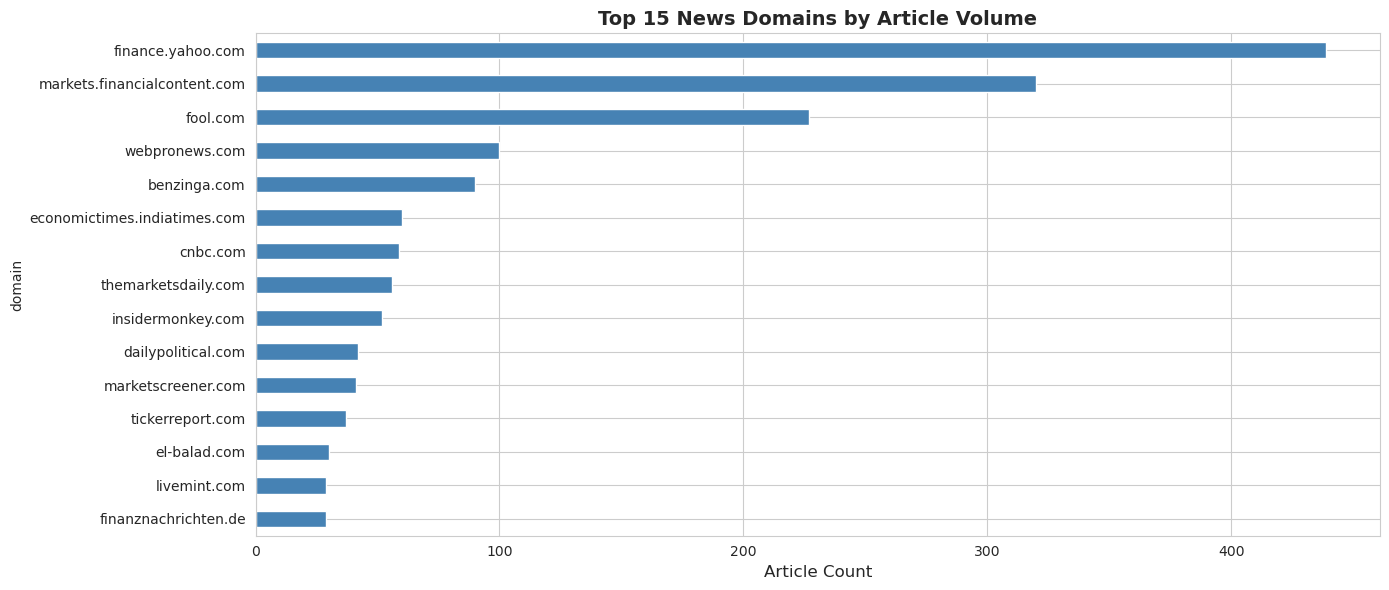

In [4]:
# Visualization: Domain concentration
fig, ax1 = plt.subplots(figsize=(14, 6))

# Top 15 domains bar chart
top_domains.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Article Count', fontsize=12)
ax1.set_title('Top 15 News Domains by Article Volume', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

plt.tight_layout()
plt.show()

## 2. Sentiment Bias by Domain

Do certain sources systematically lean positive or negative? This could indicate:
- Editorial bias
- Sensationalism
- Topic specialization (e.g., financial analysis vs. tech news)

In [5]:
# Calculate sentiment statistics by domain (for domains with 10+ articles)
domain_sentiment = df.groupby('domain').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'sentiment_present': 'mean'
}).round(3)

domain_sentiment.columns = ['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']
domain_sentiment = domain_sentiment[domain_sentiment['article_count'] >= 10].sort_values('avg_sentiment', ascending=False)


print("Sentiment Bias by Domain (10+ articles only)")
print("=" * 80)
print(f"\nMost POSITIVE domains:")
print(domain_sentiment.head(10).to_string())

print(f"\nMost NEGATIVE domains:")
print(domain_sentiment.tail(10).to_string())

Sentiment Bias by Domain (10+ articles only)

Most POSITIVE domains:
                        avg_sentiment  std_sentiment  article_count  pct_with_sentiment
domain                                                                                 
fool.com                        0.424          0.495            227               0.559
thestar.com.my                  0.411          0.565             10               0.700
manilatimes.net                 0.325          0.415             15               0.400
ibtimes.co.uk                   0.322          0.578             11               0.545
marketscreener.com              0.259          0.632             41               0.683
morningstar.com                 0.254          0.620             23               0.565
biztoc.com                      0.235          0.464             17               0.412
el-balad.com                    0.233          0.394             30               0.367
proactiveinvestors.com          0.227          0.63

## 3. Volume vs. Sentiment Relationship

Do high-volume sources show more neutral sentiment (balanced reporting)?
Or do they lean towards sensationalism?

In [6]:
domain_stats = df.groupby('domain').agg({
    'sentiment_score': 'mean',
    'url': 'count'
}).rename(columns={'url': 'article_count', 'sentiment_score': 'avg_sentiment'})

domain_stats = domain_stats[domain_stats['article_count'] >= 5]

# Add absolute sentiment (distance from neutral)
domain_stats['abs_sentiment'] = domain_stats['avg_sentiment'].abs()

# Correlation
correlation = domain_stats[['article_count', 'abs_sentiment']].corr().iloc[0, 1]

print(f"Correlation between volume and sentiment: {correlation:.3f}")
print(f"(Negative = high-volume sources tend to be more neutral)")

Correlation between volume and sentiment: 0.034
(Negative = high-volume sources tend to be more neutral)


In [65]:
# Identify domains with strong ticker preferences
for domain in top_10_domains:
    domain_df = df[df['domain'] == domain]
    ticker_dist = domain_df['ticker'].value_counts()
    top_ticker = ticker_dist.index[0]
    top_pct = (ticker_dist.iloc[0] / len(domain_df) * 100)
    
    if top_pct > 30:  # Flag if > 30% of articles focus on one ticker
        print(f"{domain:30s} heavily covers {top_ticker} ({top_pct:.1f}% of articles)")

finance.yahoo.com              heavily covers NVDA (44.7% of articles)
markets.financialcontent.com   heavily covers MSFT (30.5% of articles)
webpronews.com                 heavily covers META (31.2% of articles)


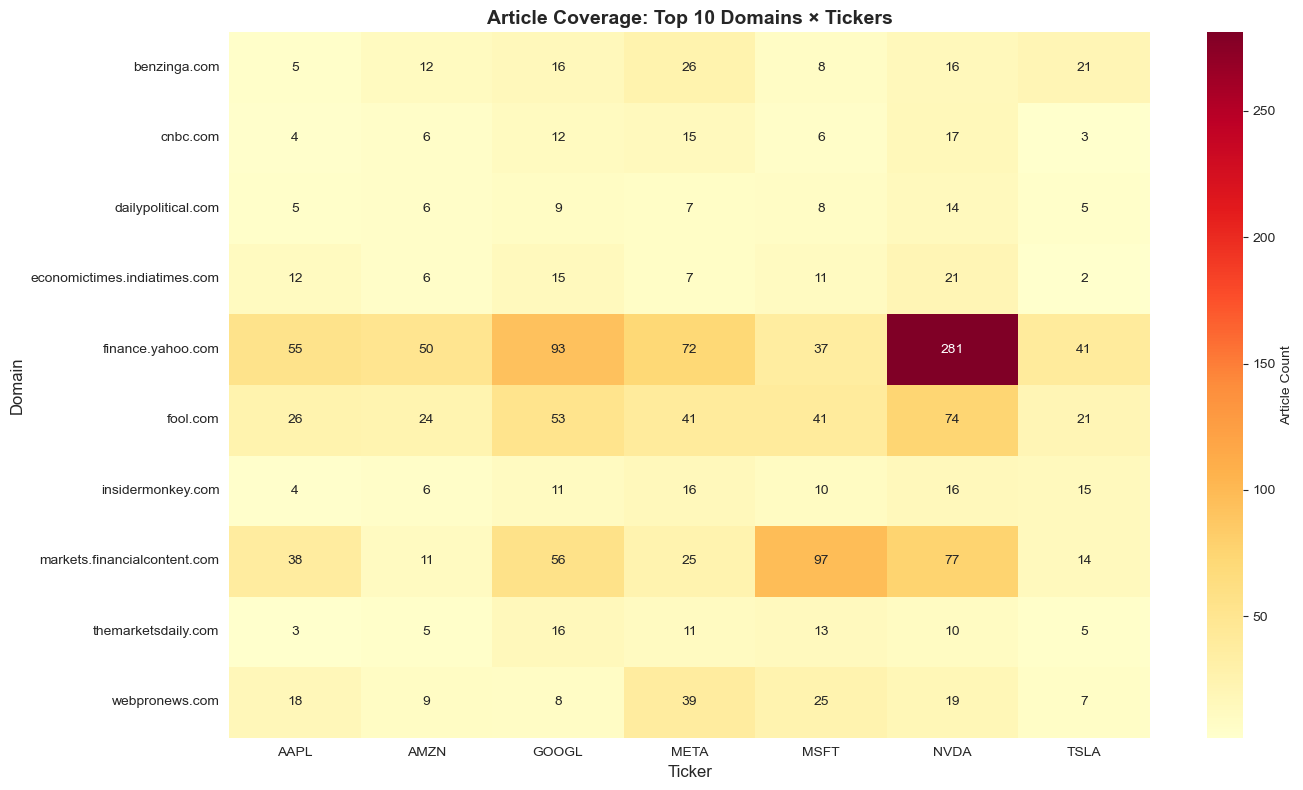

In [92]:
# Domain-ticker heatmap (top 10 domains only)
top_10_domains = domain_counts.head(10).index
df_top10 = df[df['domain'].isin(top_10_domains)]

# Create pivot table
domain_ticker_matrix = df_top10.pivot_table(
    index='domain', 
    columns='ticker', 
    values='url', 
    aggfunc='count',
    fill_value=0
)

# Heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(domain_ticker_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Article Count'}, ax=ax)
ax.set_title('Article Coverage: Top 10 Domains × Tickers', fontsize=14, fontweight='bold')
ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Domain', fontsize=12)
plt.tight_layout()
plt.show()